# Kaggle House Prices
## By: Tim Lupien

Here is how the challenge is described on Kaggle:

>Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.
>
>With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

At the time of this writing, the output of this notebook achieved a RMLSE of **0.12940**, earning me 987 / 4,303 (top 23% of all entrants) on the leaderboard.

## Basic Info

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#CC0000',
                                                    '#18548b',
                                                    '#faaf21',
                                                    '#213b1e']) 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [2]:
train_df = pd.read_csv('./train.csv', index_col='Id')
test_df = pd.read_csv('./test.csv', index_col='Id')
all_df = pd.concat([train_df,test_df])
all_df.shape

(2919, 80)

While 79 variables is certainly a lot, and it was unpleasant to do so, the first thing I did was manually review the data dictionary to split the variables into different data types based on how I wanted to treat them. These lists are the result of that effort

In [3]:
Categorical = [
    'MSSubClass',
    'MSZoning',
    'Street', # arguably binary
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2', # creative names eh
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir', # binary
    'Electrical',
    'KitchenQual',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature', # sus
    'SaleType',
    'SaleCondition',
]   

Ordinal = ['OverallQual', 'OverallCond']

Continuous = [
    'LotFrontage',
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal'
]

Discrete = [
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars',
]

Dates = [
    'YearBuilt',
    'YearRemodAdd',
    'GarageYrBlt',
    'MoSold',
    'YrSold' # probably combine these?
]

## Removing NAs

There are many NAs in this dataset.

In [4]:
na_counts = all_df.isna().sum(axis=0).sort_values(ascending=False)
na_counts[na_counts > 0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageQual       159
GarageYrBlt      159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
BsmtFullBath       2
Functional         2
Exterior2nd        1
Exterior1st        1
GarageArea         1
GarageCars         1
SaleType           1
KitchenQual        1
BsmtFinSF1         1
Electrical         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
dtype: int64

Fortunately, since I took the time to actually read the data dictionary I know that for all categorical variables with systematically missing values (read: many missing values), NA simply means that the feature a given category is describing is not present in the home.

Thus I can define the set of categorical variables with high numbers of missing values, and replace NA with some other value (I use 'No') so that the lack of a certain feature will be something the models I'll use later can interpret.

In [5]:
cat_high_na = [col for col in Categorical if col in (na_counts[na_counts >= 20].index.values)]
for col in cat_high_na:
    all_df.loc[(all_df[col].isna()==True),col] = 'No'

With that taken care of, I'm left to examine the remaining missing values:

In [6]:
na_counts = all_df.isna().sum(axis=0).sort_values(ascending=False)
na_counts[na_counts > 0]

SalePrice       1459
LotFrontage      486
GarageYrBlt      159
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
Exterior1st        1
BsmtFinSF2         1
SaleType           1
GarageCars         1
Exterior2nd        1
BsmtFinSF1         1
GarageArea         1
KitchenQual        1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
dtype: int64

SalePrice is suppposed to have that many NAs (that's the test/unlabeled data). Let's investigate LotFrontage first by taking a look at some of the other features that may be related to it

Other features, such as `LotArea`

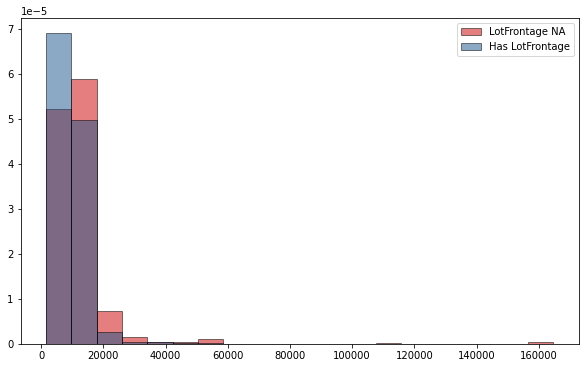

In [7]:
fig = plt.figure(figsize=(10,6))
hist1, bins, _  = plt.hist(all_df[all_df.LotFrontage.isna() == True]['LotArea'],
         bins = 20,
         edgecolor= 'k',
         density=True,
         alpha=0.5,
         label='LotFrontage NA')

plt.hist(all_df[all_df.LotFrontage.isna() == False]['LotArea'],
         bins = bins,
         edgecolor='k',
         density=True,
         alpha=0.5,
         label='Has LotFrontage')
         
plt.legend();

Looks like Lot Area is fairly similar between these.

LotConfig might be the deciding factor...

In [8]:
LotConfig_dist_dif = all_df[all_df.LotFrontage.isna()==True]['LotConfig'].value_counts(normalize=True)\
- all_df[all_df.LotFrontage.isna()==False]['LotConfig'].value_counts(normalize=True)

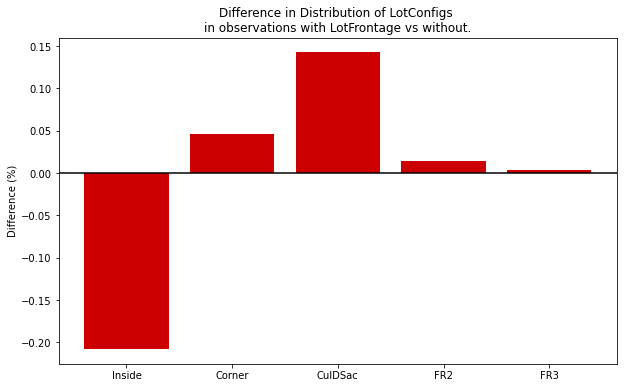

In [9]:
fig = plt.figure(figsize=(10,6))
plt.bar(LotConfig_dist_dif.index,LotConfig_dist_dif)
plt.axhline(0, c='k')
plt.title('Difference in Distribution of LotConfigs \n\
in observations with LotFrontage vs without.')
plt.ylabel('Difference (%)');

No, it is not. In fact, it's pretty opposite from what I expected, in that Inside is *under*represented in the part of the data where `LotFrontage` is NA. It still might be useful to investigate further, however.

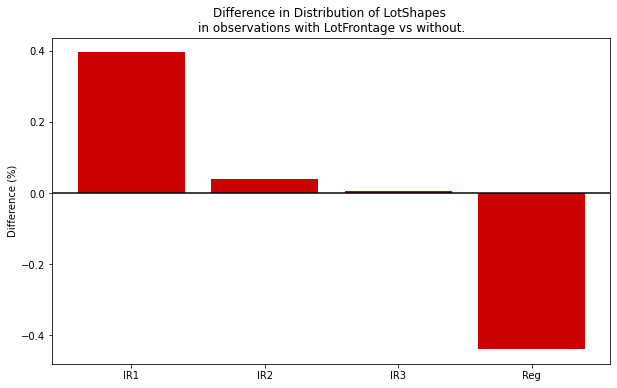

In [10]:
LotShape_dist_dif = all_df[all_df.LotFrontage.isna()==True]['LotShape'].value_counts(normalize=True)\
- all_df[all_df.LotFrontage.isna()==False]['LotShape'].value_counts(normalize=True)
fig = plt.figure(figsize=(10,6))
plt.bar(LotShape_dist_dif.index,LotShape_dist_dif)
plt.axhline(0, c='k')
plt.title('Difference in Distribution of LotShapes \n\
in observations with LotFrontage vs without.')
plt.ylabel('Difference (%)');

Lot Shape differences are minimal.

Without any clear explanation for the cause of the null values from these columns, now I'll investigate their usefulness for imputing the NAs:

In [11]:
for config in all_df.LotConfig.unique():
    print(config, all_df[all_df.LotConfig == config]['LotFrontage'].mean())

Inside 67.20569280343716
FR2 61.276923076923076
Corner 82.69041769041769
CulDSac 56.7752808988764
FR3 79.3


In [12]:
for shape in all_df.LotShape.unique():
    print(shape, all_df[all_df.LotShape == shape]['LotFrontage'].mean())

Reg 66.84887087434858
IR1 75.18083462132921
IR2 67.4375
IR3 117.63636363636364


In [13]:
for config in all_df.LotConfig.unique():
    for shape in all_df.LotShape.unique():
        print(config, shape, all_df.loc[(all_df.LotConfig == config) & (all_df.LotShape == shape), 'LotFrontage'].mean())

Inside Reg 65.1647564469914
Inside IR1 72.60136674259681
Inside IR2 86.31818181818181
Inside IR3 79.2
FR2 Reg 60.67391304347826
FR2 IR1 72.61538461538461
FR2 IR2 41.333333333333336
FR2 IR3 nan
Corner Reg 76.45487364620939
Corner IR1 93.66129032258064
Corner IR2 96.0
Corner IR3 167.75
CulDSac Reg 33.0
CulDSac IR1 57.64179104477612
CulDSac IR2 49.888888888888886
CulDSac IR3 113.5
FR3 Reg 73.83333333333333
FR3 IR1 87.5
FR3 IR2 nan
FR3 IR3 nan


Alright I'll use the combination of lot config and shape to impute the LotFrontage.

In [14]:
for config, shape, idx in zip(all_df.loc[(all_df.LotFrontage.isna() == True),'LotConfig'].values,
                    all_df.loc[(all_df.LotFrontage.isna() == True),'LotShape'].values,
                    all_df.loc[(all_df.LotFrontage.isna() == True)].index.values):
    try:
        all_df.loc[idx, 'LotFrontage'] = all_df.loc[(all_df.LotConfig==config)\
                                    & (all_df.LotShape == shape)\
                                    & (all_df.LotFrontage.isna() == False),
                                    'LotFrontage'].mean()
    except ValueError:
        print(f'There was a ValueError because there were no {config} in LotShape {shape}...')
        continue

In [15]:
na_counts = all_df.isna().sum(axis=0).sort_values(ascending=False)
na_counts[na_counts > 0]

SalePrice       1459
GarageYrBlt      159
MasVnrArea        23
MSZoning           4
Utilities          2
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Exterior1st        1
TotalBsmtSF        1
KitchenQual        1
Exterior2nd        1
BsmtFinSF1         1
GarageCars         1
GarageArea         1
BsmtUnfSF          1
BsmtFinSF2         1
SaleType           1
Electrical         1
dtype: int64

And now for GarageYrBlt. Given that there were 159 NAs in the rest of the garage-related columns, I bet these NAs represent Garages that were never built because they don't exist.

In [16]:
all_df[all_df.GarageYrBlt.isna()==True]['GarageQual'].value_counts()

No    159
Name: GarageQual, dtype: int64

Yes, exactly. Since I know I'm going to make all of the Time variables into "ages" so the models can parse them, I'll set these NAs to be the year of sale such that the corresponding age will be 0 and thus these observations will not be unduely affected by any coefficients in the model.

In [17]:
all_df.loc[(all_df.GarageYrBlt.isna()==True), 'GarageYrBlt'] = all_df.loc[(all_df.GarageYrBlt.isna()==True), 'YrSold']

I can confidently say the same for `MasVnrArea` as well (that the NAs are for houses without a Masonry Veneer) and so I'll set that to 0.

In [18]:
all_df.loc[(all_df.MasVnrArea.isna()==True), 'MasVnrArea'] = 0

For the rest of these, I again divide them by variable type.

In [19]:
na_counts = all_df.isna().sum(axis=0).sort_values(ascending=False)
na_counts[na_counts > 0]

SalePrice       1459
MSZoning           4
Utilities          2
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Exterior1st        1
KitchenQual        1
Electrical         1
SaleType           1
Exterior2nd        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
GarageCars         1
BsmtFinSF1         1
GarageArea         1
dtype: int64

In [20]:
cat_na = [col for col in Categorical if col in (na_counts[(na_counts > 0)].index.values)]
con_na = [col for col in Continuous if col in (na_counts[(na_counts > 0)].index.values)]
dis_na = [col for col in Discrete if col in (na_counts[(na_counts > 0)].index.values)]

In [21]:
cat_na

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'Electrical',
 'KitchenQual',
 'Functional',
 'SaleType']

These (categorical) can just get the mode. Although I do want to check if `KitchenQual` implies 0 kitchens first.

In [22]:
all_df[all_df.KitchenQual.isna() == True]['KitchenAbvGr']

Id
1556    1
Name: KitchenAbvGr, dtype: int64

Yes there is, indeed, a kitchen.

In [23]:
for col in cat_na:
    all_df.loc[all_df[col].isna()==True,col] = all_df[col].mode()[0]

In [24]:
con_na

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']

Similar question, do these have Basments and Garages? Let's see:

In [25]:
for col in con_na:
    print(all_df.loc[all_df[col].isna()==True,['BsmtQual','GarageQual']])

     BsmtQual GarageQual
Id                      
2121       No         TA
     BsmtQual GarageQual
Id                      
2121       No         TA
     BsmtQual GarageQual
Id                      
2121       No         TA
     BsmtQual GarageQual
Id                      
2121       No         TA
     BsmtQual GarageQual
Id                      
2577       Gd         No


It appears these can all be set to 0.

In [26]:
for col in con_na:
    all_df.loc[all_df[col].isna()==True,col] = 0

Now I'll follow the exact same process with discrete:

In [27]:
dis_na

['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']

In [28]:
for col in dis_na:
    print(col, all_df.loc[all_df[col].isna()==True,['BsmtQual','GarageQual']])

BsmtFullBath      BsmtQual GarageQual
Id                      
2121       No         TA
2189       No         TA
BsmtHalfBath      BsmtQual GarageQual
Id                      
2121       No         TA
2189       No         TA
GarageCars      BsmtQual GarageQual
Id                      
2577       Gd         No


In [29]:
for col in dis_na:
    all_df.loc[all_df[col].isna()==True,col] = 0

In [30]:
na_counts = all_df.isna().sum(axis=0).sort_values(ascending=False)
na_counts[na_counts > 0]

SalePrice    1459
dtype: int64

Hooray! No more NAs!

## Outliers

With a problem domain as diverse as houses, there are bound to be outliers. I find boxplots a useful way of examining the presence of outliers, let's make one for each of the 19 continuous variables.

In [31]:
len(Continuous)

19

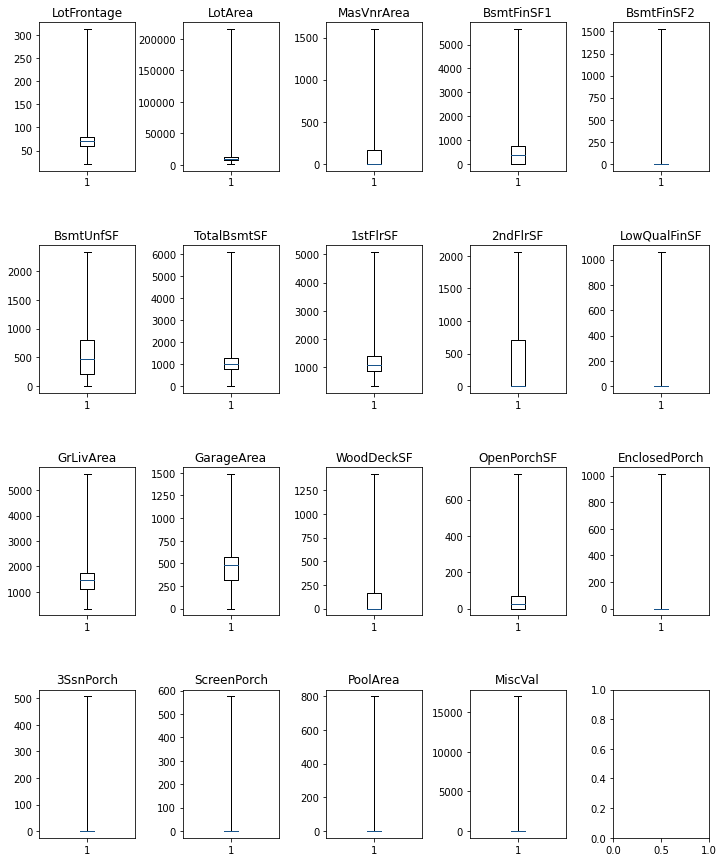

In [32]:
fig, ax = plt.subplots(4,5, figsize = (12,15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
c = 0
for i in range(4):
    for j in range(5):
        try:
            ax[i,j].boxplot(all_df[Continuous[c]],whis=(0,100))
            ax[i,j].set_title(Continuous[c])
            c += 1
        except IndexError:
            continue

There were so many outliers, I found it more helpful to look at these altered boxplots which have whiskers extending all the way to 0 and 100 percentile, rather than the usual interquartile range.

I'm still just going to chop off the top few percent, but this exercise has the important consequence of informing me **which** continuous variables actually need this treatment. Counter-intuitively, it's the ones which actually have a box in their boxplot, as the others, which appear like capital I, represent continuous variables pertaining to uncommon features, and thus any measurement is an outlier compared to the vast bulk of the distribution, which is just 0.

In [33]:
has_outliers = [
    'LotFrontage',
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'GarageArea'
]

In [34]:
all_df.shape

(2919, 80)

In [35]:
for col in has_outliers:
    
    all_df.drop(
        all_df.loc[
            (all_df[col] > all_df[col].mean() + 4 * all_df[col].std())
            & (all_df['SalePrice'].isna() == False),
            col
        ].index,
        inplace=True)
    
all_df.shape

(2876, 80)

I tried to minimize the amount I took out via this method (and only took out data from the training set), because some of the test set is outliers as well.

## Age Variables

There are several date variables represeneted in this dataset. To make them appropriate for use in machine learning models for the purpose of price prediction, I want to make them "ages" instead. This is really a minor distinction, and is easy to accomplish.

Some other notes:

- I found one erroroneous value in `GarageYrBlt` (2207). While it may be possible to send a garage back in time in that year, I doubt it has been done.
- I also construct `Remod` to indicate whether a house even underwent remodeling, as the data simple repeat the year built in the remodel year column if a house **wasn't** remodeled. I also use this to set my remodel age variable to 0.
- I encode `SaleDate` as a string variable like this because I am aware that housing markets would **not** be accurately represented by a continuous time variable, especially in the period this data is from.

In [36]:
all_df.loc[all_df['GarageYrBlt'] == 2207, 'GarageYrBlt'] = 2007
all_df['Remod'] = 0
all_df.loc[(all_df['YearRemodAdd'] != all_df['YearBuilt']),'Remod'] = 1
all_df['BuildAgeAtSale'] = all_df['YrSold'] - all_df['YearBuilt']
all_df['GarageAgeAtSale'] = all_df['YrSold'] - all_df['GarageYrBlt']
all_df['RemodAgeAtSale'] = all_df['YrSold'] - all_df['YearRemodAdd']
all_df.loc[all_df['Remod'] == 0, 'RemodAgeAtSale'] = 0
all_df['SaleDate'] = all_df['YrSold'].astype('str') + 'm' + all_df['MoSold'].astype('str')

## Minor Fixes

At one point, during the much messier exploratory data analysis work not presented here, I noticed that `Exterior2nd`, `Condition2`, and `BsmtFinType2` will actually just be exactly the same as the "1" version of their variable if there was only one exterior material, condition, or basement finish. Finding that this would be inaccurate, I chose to add a new category to each, representing that there was only one type.

Here is evidence of my claim:

In [37]:
all_df[(all_df.Exterior1st == all_df.Exterior2nd)].shape[0] / all_df.shape[0]

0.8511821974965229

In [38]:
all_df[(all_df.Condition1 == all_df.Condition2)].shape[0] / all_df.shape[0]

0.8643949930458971

The duplication is extremely obvious in these two, but less common in basements. I speculate, based on my experience observing basements over the course of my personal life, that it is very common to have a portion of the basement finished, and a portion unfinished.

In [39]:
all_df[(all_df.BsmtFinType1 == all_df.BsmtFinType2)].shape[0] / all_df.shape[0]

0.3209318497913769

In [40]:
all_df.BsmtFinType1.value_counts(normalize=True)

Unf    0.293115
GLQ    0.287552
ALQ    0.146732
Rec    0.099444
BLQ    0.092142
LwQ    0.053547
No     0.027469
Name: BsmtFinType1, dtype: float64

In [41]:
all_df.BsmtFinType2.value_counts(normalize=True)

Unf    0.855007
Rec    0.035466
LwQ    0.029555
No     0.027469
BLQ    0.022949
ALQ    0.017733
GLQ    0.011822
Name: BsmtFinType2, dtype: float64

And the data back this up as the reason why overlap is less common for basement finish types. Regardless, the overlap exists, so all 3 variables get the treatment I described above.

In [42]:
all_df.loc[(all_df.Exterior1st == all_df.Exterior2nd),'Exterior2nd'] = 'OneExt'
all_df.loc[(all_df.Condition1 == all_df.Condition2),'Condition2'] = 'OneCond' 
all_df.loc[(all_df.BsmtFinType1 == all_df.BsmtFinType2),'BsmtFinType2'] = 'OneBsmt'

Additionally, another minor fix necessary before encoding is to make `MSSubClass` into a string so it is encoded with appropriate dummy variables like a categorical variable, rather than being treated like a numerical one, as the numbers are just codes whose numerical values are irrelevant to the model.

In [43]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype('str')

## Encoding

With the preliminary work done, now it's time to create dummy variables.

In [45]:
new_cols = ['Remod','BuildAgeAtSale','GarageAgeAtSale','RemodAgeAtSale','SaleDate']
dummies = pd.get_dummies(all_df[Categorical + Discrete + Continuous + new_cols + Ordinal + ['SalePrice']])
test_df = dummies[dummies.SalePrice.isna() == True].copy()
train_df = dummies[dummies.SalePrice.isna() == False].copy()
test_df.drop(columns=['SalePrice'],inplace=True)

In [47]:
train_df.shape

(1417, 372)

In [46]:
test_df.shape

(1459, 371)

## Models

In [56]:
train_X = train_df.drop(columns=['SalePrice'])
train_y = train_df['SalePrice']
log_train_y = np.log(train_y)

Here I take the log of train_y because it works better for the lasso model and because that's how scoring is done for this competition, so the best parameters' scores will set expectations more along the lines of the actual competition score.

To make these predictions I use the logarithmic average of a Lasso Regressor and an XGBoost Regressor

### Lasso

In [52]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [57]:
lasso = make_pipeline(RobustScaler(), Lasso(max_iter=2000))
parameters = {
    'lasso__alpha': [0.00025, 0.0005, 0.00075],
}

lasso_grid = GridSearchCV(lasso,
                        parameters,
                        cv = 5,
                        verbose=True,
                        scoring='neg_root_mean_squared_error')

lasso_grid.fit(train_X, log_train_y)
print(lasso_grid.best_score_)
print(lasso_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
-0.11033446202874361
{'lasso__alpha': 0.0005}


In [81]:
Lasso_model =  make_pipeline(RobustScaler(), Lasso(alpha=0.0005,max_iter=2000))

## XGBoost

In [60]:
import xgboost

In [75]:
xgb1 = xgboost.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'tree_method':['gpu_hist'],
              'learning_rate': [0.05],
              'max_depth': [3],
              'n_estimators': [500,750,1000],
              'n_jobs':[6],
              'gpu_id':[0]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        verbose=True,
                        scoring='neg_root_mean_squared_error')

xgb_grid.fit(train_X,log_train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
-0.1160639712134451
{'gpu_id': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'n_jobs': 6, 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist'}


In [76]:
xgb_model = xgboost.XGBRegressor(**xgb_grid.best_params_)

### Blending

In [82]:
Lasso_model.fit(train_X,log_train_y)
xgb_model.fit(train_X,log_train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=6, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [83]:
Lasso_pred = Lasso_model.predict(test_df)
xgb_pred = xgb_model.predict(test_df)

In [87]:
blended = np.exp((Lasso_pred + xgb_pred) / 2)

In [88]:
blended

array([125567.36960794, 157216.45790962, 183206.72851663, ...,
       150570.72443438, 117518.17494204, 228444.49705271])

## Generate Submission

In [89]:
submission = pd.DataFrame({'Id':test_df.index, 'SalePrice':blended})
submission.to_csv('./submission.csv',index=False)